# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi
!rm -rf sample_data

Mon Nov 28 09:49:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


#**3. Téléchargement des données d'entrainement "Small Suspect Dataset"**

In [30]:
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/suspect_classification/Big_Suspect_Database.zip
!unzip Big_Suspect_Database.zip
!rm Big_Suspect_Database.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Big_Suspect_Database/train/armes/1875.jpg  
  inflating: Big_Suspect_Database/train/armes/1876.jpeg  
  inflating: Big_Suspect_Database/train/armes/1877.jpg  
  inflating: Big_Suspect_Database/train/armes/1878.jpg  
  inflating: Big_Suspect_Database/train/armes/1879.jpg  
  inflating: Big_Suspect_Database/train/armes/1880.jpg  
  inflating: Big_Suspect_Database/train/armes/1881.jpg  
  inflating: Big_Suspect_Database/train/armes/1882.jpg  
  inflating: Big_Suspect_Database/train/armes/1883.jpg  
  inflating: Big_Suspect_Database/train/armes/1884.jpg  
  inflating: Big_Suspect_Database/train/armes/1885.jpg  
  inflating: Big_Suspect_Database/train/armes/1886.jpg  
  inflating: Big_Suspect_Database/train/armes/1887.jpg  
  inflating: Big_Suspect_Database/train/armes/1888.jpg  
  inflating: Big_Suspect_Database/train/armes/1889.jpg  
  inflating: Big_Suspect_Database/train/armes/1890.jpeg  
  inflat

#**5. Création du fichier de labels "classes.txt"**

In [31]:
!printf '%s\n' 'appareil_photo' 'arme' 'autres' 'baton' 'couteau' 'drone' 'gillet_jaune' 'grenade' 'personne'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [32]:
nb_classes = 9
batch_size=32 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=20 #@param [2, 5, 10,20,50,100,200] {type:"raw"}
dataset_name='Big_Suspect_Database' #@param ["Small_Suspect_Database","Big_Suspect_Database","Personal_Database"]
train_dataset = os.path.join(dataset_name, 'train/')
test_dataset = os.path.join(dataset_name, 'test/')
input_dim=224 #@param [224,299] {type:"raw"}  
classes_path = "classes.txt"
classifier = "MobileNet" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}

# **7. Compter le nombre de classes**

In [33]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim),        # Taille des images d'entrée
	batch_size=32,           # Taille du mini-batch
  label_mode="categorical"  # Conversion au format One-Hot
)

Found 5427 files belonging to 9 classes.
Using 4342 files for training.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot")**

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(224,224),        # Taille des images d'entrée
	batch_size=32,           # Taille du mini-batch
  label_mode="categorical"  # Conversion au format One-Hot
)

Found 5427 files belonging to 9 classes.
Using 4342 files for training.


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [36]:
base_model = tf.keras.applications.MobileNet(
    input_shape=(input_dim,input_dim,3),
    alpha=1.0,
    include_top=None,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=9,
    classifier_activation="softmax",
    
)
x = base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)
model=Model(inputs=base_model.inputs, outputs=predictions)

# **11. Geler puis dégeler les poids des premières couches**

In [37]:
for layers in model.layers :  
  layers.trainable=True

# **11. Compiler le modèle : loss=cross_entropy, optimizer = dsg, metrics = acc**


In [38]:
# recompiler le modèle
tf.keras.backend.clear_session()  # réinitialiser les poids du modèle
keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False)
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

# **12. Entraîner le modèle**

In [20]:
stopper=EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=5,
                      verbose=1,
                      mode='auto')
ckpt_save=os.path.join(".",'model_fine_ep{epoch}_vallos{val_loss:.3f}.h5')
checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callback_list = [checkpoint, stopper]


In [39]:
print('Model1')
history=model.fit(train_ds,
                       steps_per_epoch=math.ceil(len(train_ds)),
                       epochs=epochs,
                       validation_data=val_ds,
                       validation_steps=math.ceil(len(val_ds)),
                       verbose=1)

Model1
Epoch 1/20
136/136 [==============================] - 62s 433ms/step - loss: 0.6077 - accuracy: 0.8176 - val_loss: 0.2189 - val_accuracy: 0.9463
Epoch 2/20
136/136 [==============================] - 59s 423ms/step - loss: 0.2069 - accuracy: 0.9424 - val_loss: 0.0907 - val_accuracy: 0.9848
Epoch 3/20
136/136 [==============================] - 59s 424ms/step - loss: 0.1111 - accuracy: 0.9754 - val_loss: 0.0476 - val_accuracy: 0.9956
Epoch 4/20
136/136 [==============================] - 59s 427ms/step - loss: 0.0756 - accuracy: 0.9839 - val_loss: 0.0273 - val_accuracy: 0.9984
Epoch 5/20
136/136 [==============================] - 59s 425ms/step - loss: 0.0472 - accuracy: 0.9910 - val_loss: 0.0168 - val_accuracy: 0.9995
Epoch 6/20
136/136 [==============================] - 59s 426ms/step - loss: 0.0312 - accuracy: 0.9977 - val_loss: 0.0112 - val_accuracy: 0.9998
Epoch 7/20
136/136 [==============================] - 59s 425ms/step - loss: 0.0281 - accuracy: 0.9975 - val_loss: 0.0076 -

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [40]:
model.save('./model_Mat.h5')

#**14. Afficher des courbes d'entrainement/validation**

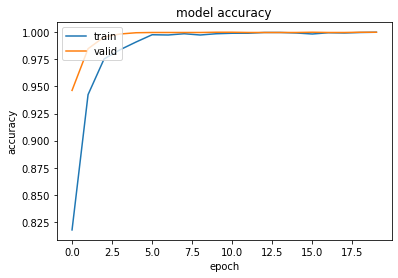

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# **15. Créer le jeu de données de test**

In [42]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
	test_dataset,               # chemin vers le jeu de données
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(224,224),        # Taille des images d'entrée
	batch_size=32,           # Taille du mini-batch
  label_mode="categorical"  # Conversion au format One-Hot
)

Found 1405 files belonging to 9 classes.


# **16. Evaluer le modèle avec ce jeu de données de test**

In [43]:
train_accuracy=model.evaluate(train_ds, steps=len(train_ds), verbose=0)[1]
print("Train accuracy = ", train_accuracy)
test_accuracy=model.evaluate(test_ds, steps=len(test_ds),verbose=0)[1]
print("Test accuracy = ", test_accuracy)

Train accuracy =  1.0
Test accuracy =  0.9665480256080627


#**16. Tester le résultat visuel de votre modèle avec 10 images de test**

Small_Suspect_Database/test/appareil_photo/1.jpg
1/1 [==============================] - 0s 399ms/step
Class Name : appareil_photo --- Class Probability: 99.99%
Small_Suspect_Database/test/appareil_photo/18.jpg
1/1 [==============================] - 0s 19ms/step
Class Name : appareil_photo --- Class Probability: 100.00%
Small_Suspect_Database/test/armes/105.jpg
1/1 [==============================] - 0s 20ms/step
Class Name : armes --- Class Probability: 99.98%
Small_Suspect_Database/test/armes/121.jpg
1/1 [==============================] - 0s 21ms/step
Class Name : armes --- Class Probability: 100.00%
Small_Suspect_Database/test/autres/395.jpg
1/1 [==============================] - 0s 22ms/step
Class Name : autres --- Class Probability: 82.36%
Small_Suspect_Database/test/baton/438.jpg
1/1 [==============================] - 0s 18ms/step
Class Name : baton --- Class Probability: 99.99%
Small_Suspect_Database/test/drones/777.jpg
1/1 [==============================] - 0s 31ms/step
Class Nam

<Figure size 432x288 with 0 Axes>

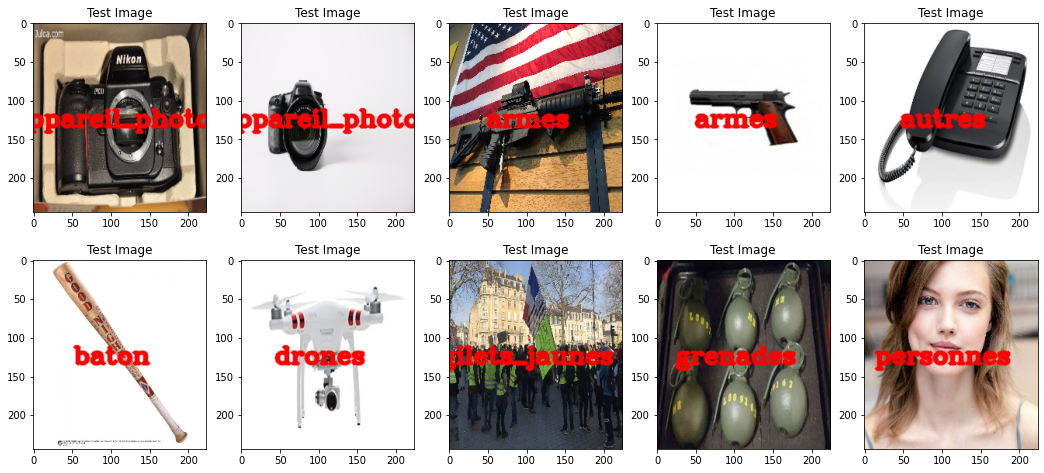

In [44]:
classes = train_ds.class_names
images_to_test = ["Small_Suspect_Database/test/appareil_photo/1.jpg",
                  "Small_Suspect_Database/test/appareil_photo/18.jpg",
                  "Small_Suspect_Database/test/armes/105.jpg",
                  "Small_Suspect_Database/test/armes/121.jpg",
                  "Small_Suspect_Database/test/autres/395.jpg",
                  "Small_Suspect_Database/test/baton/438.jpg",
                  "Small_Suspect_Database/test/drones/777.jpg",
                  "Small_Suspect_Database/test/gilets_jaunes/1040.jpg",
                  "Small_Suspect_Database/test/grenades/1222.jpg",
                  "Small_Suspect_Database/test/personnes/1314.jpg",
]

axes=[]
fig=plt.figure()
fig = plt.figure(figsize=(18,8))
i=0
for image_path in images_to_test:
    i+=1
    print(image_path)
    img = Image.open(image_path).convert('RGB')
    x = tf.keras.utils.img_to_array(img,data_format='channels_last')
    x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x,batch_size=64)[0]
    for (pos,prob) in enumerate(pred):
      class_name = classes[pos]
      if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,244))
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 1, (255,0,0), 4, cv2.LINE_AA)
        axes.append(fig.add_subplot(2, 5, i) )
        axes[-1].set_title("Test Image")  
        plt.imshow(img)
        print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()